### Testing Boosted Decision Tree based Anomaly Detection on simulated data

#### This code generates large dataframe containing multiple timeseries, randomly adds changes in both mean and variance (anomalies), tries to train a BDT to distinguish measurements belonging to the timebin under investigation from measurements in a reference time period.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)  

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

from pandas.tseries.offsets import *

import simulated_data
from graphviz import Source

#### parameters to set

In [2]:
cut = 0.55
window = 24

#### generate data

In [3]:
# df =  simulated_data.get_simulated_data()
df =  simulated_data.get_simulated_fixed_data()
df.head()

mean:  [ 0.23086387  0.51582471  0.56651978  0.42169494  0.38018046  0.36357677]
sigma:  [ 0.00357143  0.00833333  0.0125      0.00416667  0.00416667  0.005     ]
affected: [0] 2017-08-02 01:00:00 2017-08-02 02:00:00
affected: [0] 2017-08-03 01:00:00 2017-08-03 04:00:00
affected: [0, 3, 4] 2017-08-04 01:00:00 2017-08-04 02:00:00
affected: [0] 2017-08-05 01:00:00 2017-08-05 02:00:00
affected: [0] 2017-08-06 01:00:00 2017-08-06 04:00:00
affected: [0, 3, 4] 2017-08-07 01:00:00 2017-08-07 02:00:00


,link 0,link 1,link 2,link 3,link 4,link 5,flag
2017-08-01 00:00:00,0.230178,0.506560,0.554047,0.420541,0.380460,0.359599,0
2017-08-01 00:00:01,0.229532,0.521725,0.577484,0.421780,0.375597,0.369415,0
2017-08-01 00:00:02,0.228173,0.512503,0.562112,0.427291,0.385642,0.360890,0
2017-08-01 00:00:03,0.220974,0.520249,0.580333,0.423265,0.375781,0.370157,0
2017-08-01 00:00:04,0.231178,0.519124,0.578206,0.422570,0.373971,0.354588,0


#### plot timeseries. Can take a minute to appear due to plot size and complexity.

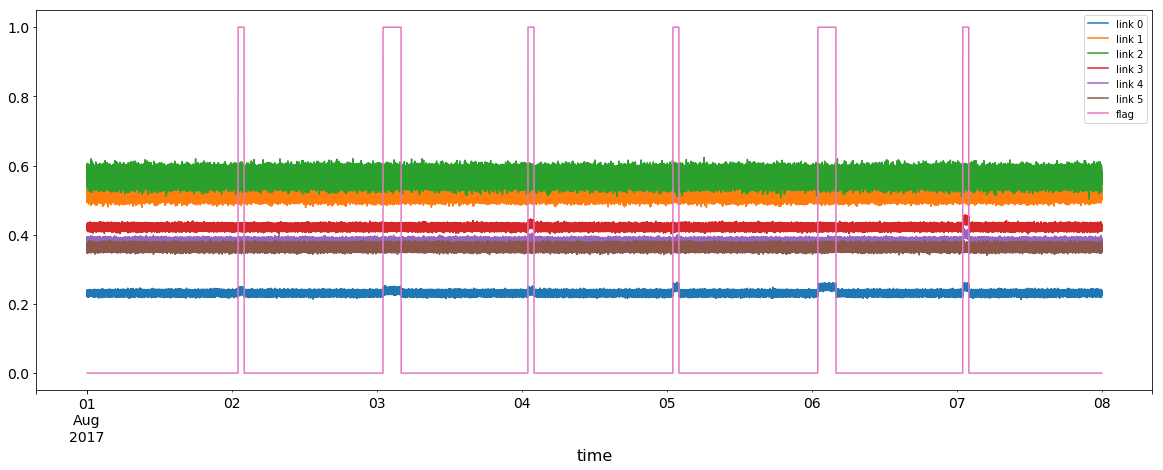

In [4]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=16)
plt.savefig('simulated_fixed.png')

#### functions to check for anomaly and plot roc curves. 

check_for_anomaly fuction receives both reference and subject dataframes, creates training and testing frames, does classification, tests it, prints auc results, and creates ROC curves when abouve the cut.
No outut is expected form this cell.

In [5]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    del X_ref['flag']
    del X_ref['auc_score']
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    del X_sub['flag']
    del X_sub['auc_score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    clf = AdaBoostClassifier() #dtc
#     clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ("auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > cut: 
        plot_roc(fpr, tpr, auc_score)
        filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
        tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
        tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score


def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

#### Looping over time intervals

This function actully runs anomaly dection over all the intervals. It takes only few seconds per interval, but plot generation takes 10-20 seconds.  

auc_score =  0.499961419753 	feature importances: [ 0.08  0.22  0.2   0.16  0.2   0.14]
2017-08-02 01:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499961419753
auc_score =  0.593287037037 	feature importances: [ 0.78  0.    0.04  0.08  0.02  0.08]


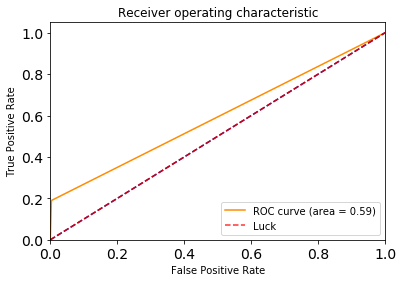

2017-08-02 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.593287037037
auc_score =  0.499980709877 	feature importances: [ 0.3   0.18  0.14  0.1   0.12  0.16]
2017-08-02 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.5 	feature importances: [ 0.26  0.14  0.06  0.14  0.3   0.1 ]
2017-08-02 04:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.1   0.26  0.16  0.2   0.14  0.14]
2017-08-02 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.28  0.18  0.26  0.04  0.16  0.08]
2017-08-02 06:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.32  0.08  0.12  0.08  0.14  0.26]
2017-08-02 07:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.49994212963 	feature importances: [ 0.28  0.06  0.14  0.22  0.08  0.22]
2017-08-02 08:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212963
auc_score =  0.499980709877 	feature importances: [ 0.28  0.12  0

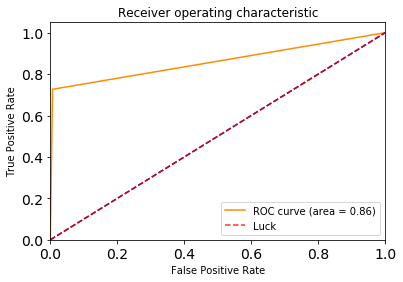

2017-08-04 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.860127314815
auc_score =  0.499980709877 	feature importances: [ 0.3   0.16  0.1   0.2   0.06  0.18]
2017-08-04 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.499980709877 	feature importances: [ 0.32  0.06  0.12  0.1   0.28  0.12]
2017-08-04 04:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.499980709877 	feature importances: [ 0.22  0.12  0.14  0.2   0.24  0.08]
2017-08-04 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.5 	feature importances: [ 0.22  0.12  0.18  0.2   0.26  0.02]
2017-08-04 06:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.499980709877 	feature importances: [ 0.2   0.12  0.12  0.28  0.16  0.12]
2017-08-04 07:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.499922839506 	feature importances: [ 0.26  0.08  0.08  0.28  0.16  0.14]
2017-08-04 08:00:00 	refes: 86400 	subjects: 3600 	auc: 0.4999228395

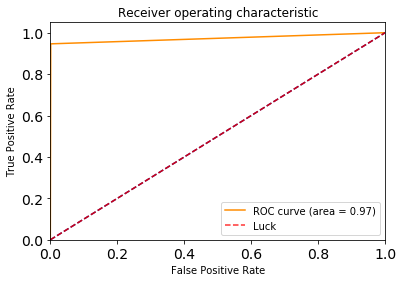

2017-08-05 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.972530864198
auc_score =  0.5 	feature importances: [ 0.28  0.1   0.18  0.12  0.2   0.12]
2017-08-05 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.499961419753 	feature importances: [ 0.3   0.22  0.2   0.06  0.1   0.12]
2017-08-05 04:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499961419753
auc_score =  0.499980709877 	feature importances: [ 0.22  0.12  0.22  0.16  0.12  0.16]
2017-08-05 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.5 	feature importances: [ 0.24  0.22  0.12  0.18  0.1   0.14]
2017-08-05 06:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.499961419753 	feature importances: [ 0.34  0.1   0.12  0.14  0.2   0.1 ]
2017-08-05 07:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499961419753
auc_score =  0.5 	feature importances: [ 0.18  0.12  0.22  0.1   0.22  0.16]
2017-08-05 08:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.500462962963 	feature impo

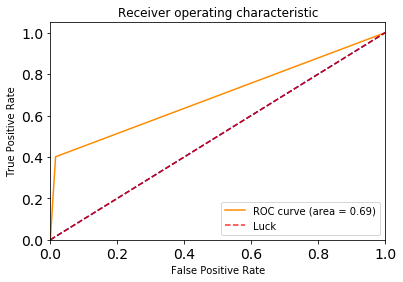

2017-08-06 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.692611882716
auc_score =  0.702141203704 	feature importances: [ 0.46  0.08  0.14  0.14  0.14  0.04]


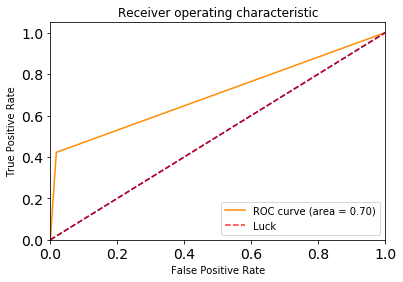

2017-08-06 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.702141203704
auc_score =  0.502488425926 	feature importances: [ 0.66  0.    0.06  0.14  0.06  0.08]
2017-08-06 04:00:00 	refes: 86400 	subjects: 3600 	auc: 0.502488425926
auc_score =  0.499961419753 	feature importances: [ 0.34  0.2   0.1   0.06  0.08  0.22]
2017-08-06 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499961419753
auc_score =  0.5 	feature importances: [ 0.28  0.16  0.1   0.18  0.16  0.12]
2017-08-06 06:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.22  0.08  0.2   0.1   0.12  0.28]
2017-08-06 07:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.3   0.1   0.26  0.14  0.1   0.1 ]
2017-08-06 08:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.18  0.18  0.18  0.18  0.06  0.22]
2017-08-06 09:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.49994212963 	feature importances: [ 0.16  0.26  

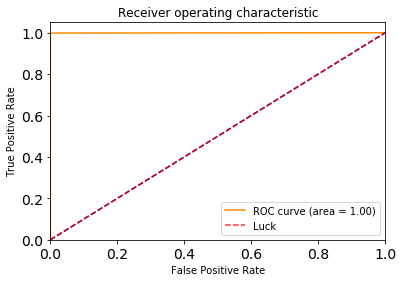

2017-08-07 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.999054783951
auc_score =  0.49994212963 	feature importances: [ 0.12  0.38  0.12  0.14  0.12  0.12]
2017-08-07 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212963
auc_score =  0.5 	feature importances: [ 0.3   0.12  0.16  0.12  0.12  0.18]
2017-08-07 04:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.499961419753 	feature importances: [ 0.32  0.08  0.12  0.12  0.24  0.12]
2017-08-07 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499961419753
auc_score =  0.5 	feature importances: [ 0.18  0.12  0.14  0.16  0.1   0.3 ]
2017-08-07 06:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.14  0.14  0.18  0.2   0.16  0.18]
2017-08-07 07:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.18  0.16  0.12  0.24  0.2   0.1 ]
2017-08-07 08:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.16  0.12  0.24  0.04  

In [6]:
df['auc_score']=0.5

#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    auc_score = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['auc_score']] = auc_score
    print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    #if count>2: break
    


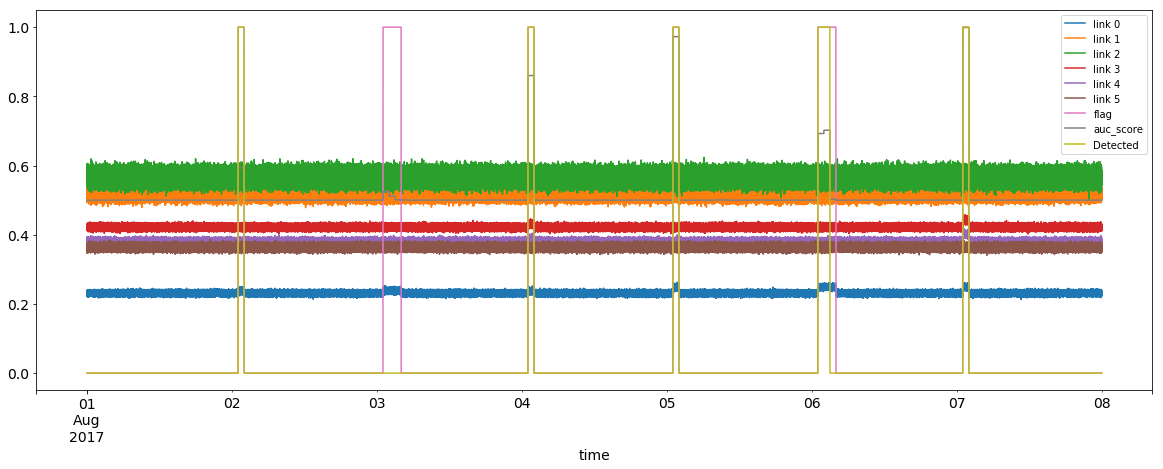

In [10]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)
plt.savefig('BDT_simulated_fixed.png')

#### make plot of created anomalies, auc values, and shade periods where anomaly is suspected.

AttributeError: 'DataFrame' object has no attribute 'auc_score'

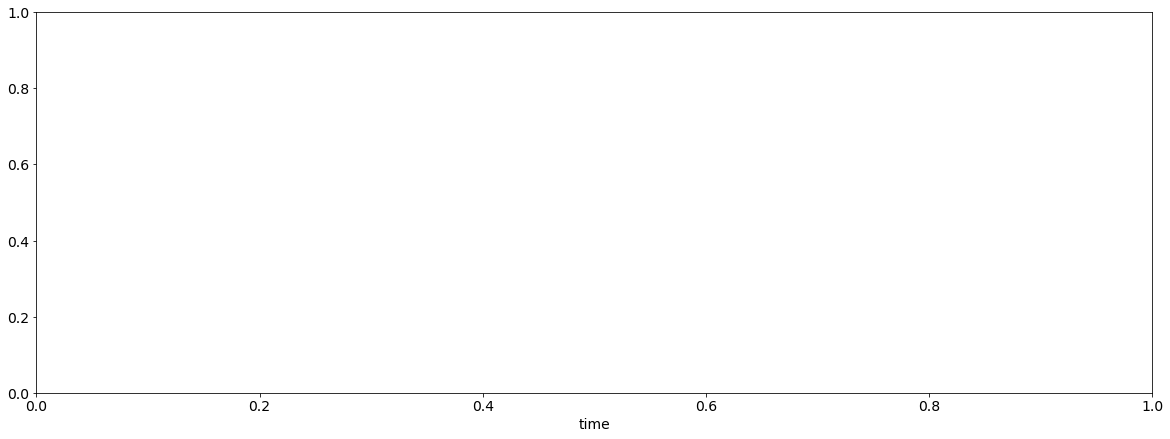

In [5]:
fig, ax = plt.subplots(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)
df.loc[:,'Detected'] = 0
df.loc[df.auc_score>0.55,'Detected']=1
df.head()
ax.plot(df.flag, 'r')
ax.plot(df.auc_score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()
fig.savefig('BDT_shaded_simulated_fixed.png')